# Exploring the Airbnb contract network

**TODO**: Add a general description of the objectives related to this digital contract science notebook.

This notebook uses Graphistry for visual network analysis.

In [18]:
import json
with open('../config.json') as f:
    config = json.load(f)

In [19]:
import graphistry
graphistry.register(
    api=3, protocol="https", server="hub.graphistry.com", 
    username=config['graphistry_username'], password=config['graphistry_password'])

In [20]:
import pandas as pd

Reading the full contract dataset:

In [21]:
df_events = pd.read_pickle('data/CONTRACT_EVENTS.pkl')

In [22]:
df_events.head()

,CONTRACT_MODEL_ID,MODEL_INSTANCE,TIME_STAMP,PARTIES_PROPOSER_ID,PARTIES_PARTICIPANT_ID,ASSET_ID,EVENT_TYPE
0,XkAYDhgbMY,ND,2015-04-10,62142,30537860,15883,location in B&B
1,q2hmWu2x7R,ND,2016-06-19,62142,37529754,15883,location in B&B
2,zwkeK82VN3,ND,2016-07-29,62142,3147341,15883,location in B&B
3,5JA6pqZ4U3,ND,2016-08-13,62142,29518067,15883,location in B&B
4,nPCvCNf3TO,ND,2016-11-21,62142,36016357,15883,location in B&B


In [23]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2171151 entries, 0 to 2171150
Data columns (total 7 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   CONTRACT_MODEL_ID       object        
 1   MODEL_INSTANCE          object        
 2   TIME_STAMP              datetime64[ns]
 3   PARTIES_PROPOSER_ID     int64         
 4   PARTIES_PARTICIPANT_ID  int64         
 5   ASSET_ID                int64         
 6   EVENT_TYPE              object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 116.0+ MB


In [24]:
#!pip install python-igraph

In [25]:
# !pip install seaborn
import seaborn as sns

In [26]:
df_events_timeline = df_events.groupby([pd.Grouper(key='TIME_STAMP', freq="1D")]).agg({'CONTRACT_MODEL_ID': ['count']})
df_events_timeline.columns = df_events_timeline.columns.droplevel(level=0)


In [27]:
df_events_timeline.sort_values(['count'], ascending=False).head()

,count
TIME_STAMP,
2019-06-02,4095
2019-11-03,3964
2019-12-01,3888
2019-10-06,3875
2020-01-02,3769


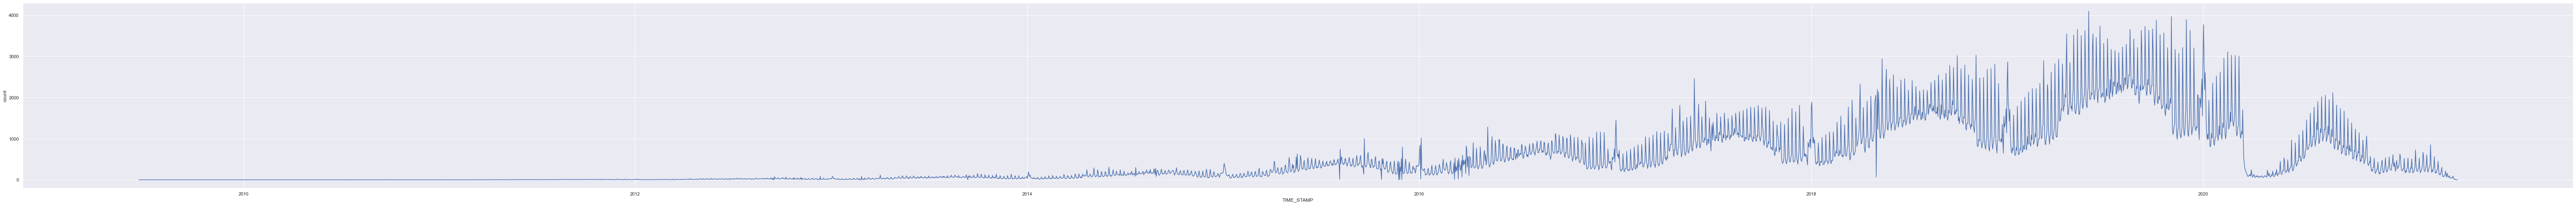

In [28]:
sns.set(rc={'figure.figsize':(110.7,8.27)})
g = sns.lineplot(x="TIME_STAMP", y="count",
             data=df_events_timeline) 


In [29]:
g_sample = graphistry.bind(source='PARTIES_PROPOSER_ID', destination='PARTIES_PARTICIPANT_ID')

In [30]:
g_sample.edges(df_events).plot()

In [31]:
df_events.head()

,CONTRACT_MODEL_ID,MODEL_INSTANCE,TIME_STAMP,PARTIES_PROPOSER_ID,PARTIES_PARTICIPANT_ID,ASSET_ID,EVENT_TYPE
0,XkAYDhgbMY,ND,2015-04-10,62142,30537860,15883,location in B&B
1,q2hmWu2x7R,ND,2016-06-19,62142,37529754,15883,location in B&B
2,zwkeK82VN3,ND,2016-07-29,62142,3147341,15883,location in B&B
3,5JA6pqZ4U3,ND,2016-08-13,62142,29518067,15883,location in B&B
4,nPCvCNf3TO,ND,2016-11-21,62142,36016357,15883,location in B&B


In [32]:
df_edges = df_events[['PARTIES_PROPOSER_ID', 'PARTIES_PARTICIPANT_ID']]

In [33]:
df_edges.head()

,PARTIES_PROPOSER_ID,PARTIES_PARTICIPANT_ID
0,62142,30537860
1,62142,37529754
2,62142,3147341
3,62142,29518067
4,62142,36016357


In [34]:
df_edges.to_csv('edgelist.txt', index=False, header=False, sep=' ')

In [35]:
import networkx as nx

ModuleNotFoundError: No module named 'networkx'

[Graphmonster](https://github.com/simonlindgren/graphmonster) introduces a nice example on how to simplify a very large graph for visualization. Let's apply some parts of the process here.

In [ ]:
# From graphmonster
G = nx.DiGraph()
for edge in df_edges.itertuples():
    # print(edge)
    s = edge.PARTIES_PROPOSER_ID
    t = edge.PARTIES_PARTICIPANT_ID

    if G.has_edge(s,t):
        G[s][t]['weight'] += 1
    else:
        G.add_edge(s, t, weight = 1)

In [ ]:
len(G.nodes())

with open(file, "r") as edgelist:
    for e in edgelist.readlines():
        try:
            s = e.split()[0]
            t = e.split()[1]
        except:
            print("----- Your edgelist has the wrong format!")
            sys.exit()
        if G.has_edge(s,t):
            G[s][t]['weight'] += 1
        else:
            G.add_edge(s,t,weight = 1)

In [ ]:
nx.write_gexf(G, "full_network.gexf")

In [ ]:
# Calculating PageRank to identify key nodes or supernodes in the network
pr = nx.pagerank(G)
# Setting page rank values for nodes
nx.set_node_attributes(G, pr, 'pagerank')
nx.set_node_attributes(G, values= nx.in_degree_centrality(G), name='indegree')
# nx.set_node_attributes(G, values=G.out_degree(), name='outdegree')

In [ ]:
# G.in_degree()

Creating a data frame for nodes:

In [ ]:
nodes = dict(G.nodes(data=True))

df_nodes = pd.DataFrame.from_dict(nodes, orient='index')
df_nodes['nodeid'] = nodes.keys()
df_nodes = df_nodes.sort_values('pagerank', ascending=False)
df_nodes['nodeid'] = df_nodes.nodeid.astype(int)
df_nodes.head()

In [ ]:
df_nodes.info()

In [ ]:
# df_nodes[df_nodes.nodeid == 8520099]

In [ ]:
# pr

In [ ]:
# Finding the giant component
components = sorted(nx.connected_components(G), key=len, reverse=True)

In [ ]:
len(components[0])

In [ ]:
giant_component = G.subgraph(components[0])

In [ ]:
# graphistry.bind(source='src', destination='dst', node='nodeid').plot(giant_component)

In [ ]:
df_nodes.head()

In [ ]:
# Exploring the top node according to PageRank

top_pr = df_nodes.sort_values('pagerank', ascending=False).iloc[0]
int(top_pr.nodeid)

In [ ]:
ego_g = nx.ego_graph(G, int(top_pr.nodeid), radius=2, undirected=True)

In [ ]:
import ipycytoscape
import ipywidgets as widgets
# import networkx as nx


In [ ]:
directed = ipycytoscape.CytoscapeWidget()
directed.graph.add_graph_from_networkx(ego_g, directed=True)
# directed.set_layout(name='grid')
display(directed)

In [ ]:
graphistry.bind(source='src', destination='dst', node='nodeid').plot(ego_g)

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# tips = sns.load_dataset("tips")

g = sns.jointplot(x="pagerank", y="indegree", data=df_nodes,
                  kind="reg", 
                  truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
# g.set(xscale="log", yscale="log")

In [ ]:
g = sns.relplot(
    data=df_nodes,
    x="pagerank", y="indegree",
    #hue="year", size="mass",
    # palette=cmap, 
    #sizes=(10, 200),
)

In [ ]:
test = nx.DiGraph()
test.add_edge('a', 'b', label='testing')

In [ ]:
len(df_nodes)

In [ ]:
testing = ipycytoscape.CytoscapeWidget()
testing.graph.add_graph_from_networkx(test, directed=True)
# directed.set_layout(name='grid')
display(testing)